# AlexNet

Running AlexNet on fruits & vegetables dataset.

Model references:

- <https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html>
- <https://arxiv.org/pdf/1404.5997>


In [40]:
import json
import requests
import torch
import matplotlib.pyplot as plt
from torchvision.models import alexnet, AlexNet_Weights
from torch.utils.data import DataLoader

from cvision.data import get_fruits, VisionDataset

In [2]:
weights = AlexNet_Weights.IMAGENET1K_V1
model = alexnet(weights=weights)

In [3]:
data = get_fruits(remote="", localdir="/mnt/e/torch/fruits", force=False)

Data already exists.


## Test the pretrained model

Check AlexNet output before customizing prediction head.

In [4]:
model.eval()
transform = weights.transforms()

In [5]:
transform # OK

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [10]:
# get a batch of random images

ds_test = data["test_dataset"]
ds_test.set_transform(transform)
loader = DataLoader(ds_test, batch_size=32, shuffle=True)

images, labels = next(iter(loader))

In [12]:
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [19]:
logits = model(images)
probs = torch.softmax(logits, dim=1)
preds = torch.argmax(probs, dim=1)

In [22]:
preds

tensor([998, 945, 951, 938, 998, 310, 990, 989, 964, 945, 673, 117, 954, 950,
        940, 989, 852, 324, 938, 938, 948, 945, 953, 989, 945, 936, 952, 953,
        947, 945, 945, 957])

In [30]:
# get imagenet class names from keras, you might need a different url if this breaks

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
res = requests.get(url)
res.raise_for_status()
classes = json.loads(res.content) # formatted as cl_idx dict: {"n": ["id", "name"]}

In [37]:
pred_classes = [classes[str(pred.item())][1] for pred in preds]

In [39]:
pred_classes[:5] # OK

['ear', 'bell_pepper', 'lemon', 'cauliflower', 'ear']

In [61]:
# renormalize batch

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

batch_re = images * std + mean
batch_re = torch.clamp(batch_re, 0, 1)

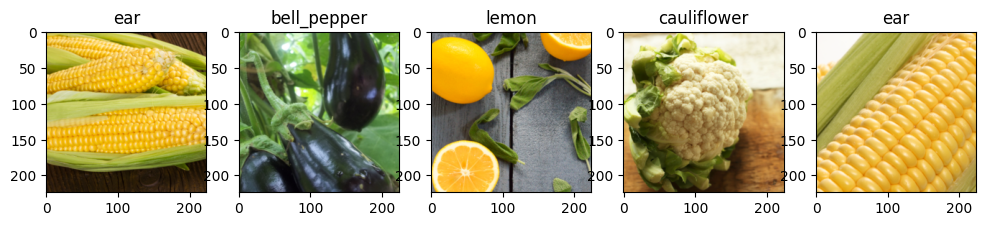

In [68]:
f, ax = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    ax[i].imshow(batch_re[i].permute(1, 2, 0))
    ax[i].set_title(pred_classes[i])